In [1]:
# !pip install scanpy==1.9.5

In [2]:
# !pip install leidenalg

### 1. Import packages & read in data

In [3]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import os

In [5]:
# read in dataset
adata = sc.read_10x_h5('Project_Counts.h5') 

C:\Users\Roger\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\Roger\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### 2. Data preprocessing

In [6]:
# ensure unique variable names
adata.var_names_make_unique() 

In [7]:
# inspect object
adata 

AnnData object with n_obs × n_vars = 11316 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

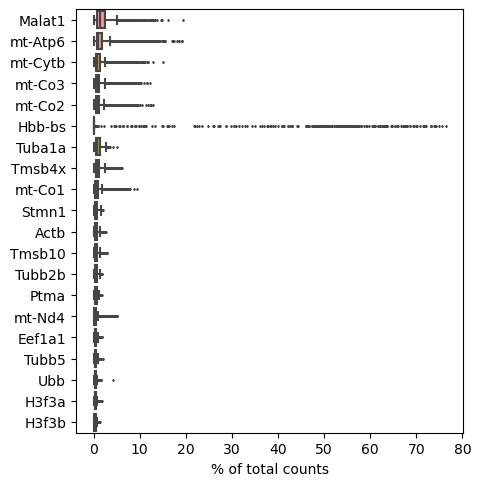

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
# filter out cells with fewer than 200 detected genes (remove cells of low quality)
sc.pp.filter_cells(adata, min_genes=200)
# filter out genes detected in fewer than 3 cells (reduce dimensionality and focus on relevent genes)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
# create new column specifying whether it's mitochondrial genes
adata.var['mt'] = adata.var_names.str.contains('^MT-|^mt-', regex=True)
# compute quality control metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
# display all mitochondrial genes
adata[:, adata.var['mt'] == True].var

,gene_ids,feature_types,genome,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
mt-Nd1,ENSMUSG00000064341,Gene Expression,mm10,10727,True,10727,17.353638,5.163116,196287.0
mt-Nd2,ENSMUSG00000064345,Gene Expression,mm10,10799,True,10799,19.765802,4.526567,223571.0
mt-Co1,ENSMUSG00000064351,Gene Expression,mm10,11100,True,11100,64.074089,1.865441,724742.0
mt-Co2,ENSMUSG00000064354,Gene Expression,mm10,11145,True,11145,80.923080,1.467598,915321.0
mt-Atp8,ENSMUSG00000064356,Gene Expression,mm10,6048,True,6048,1.053753,46.529927,11919.0
mt-Atp6,ENSMUSG00000064357,Gene Expression,mm10,11219,True,11219,127.844574,0.813368,1446050.0
mt-Co3,ENSMUSG00000064358,Gene Expression,mm10,11190,True,11190,85.596497,1.069755,968182.0
mt-Nd3,ENSMUSG00000064360,Gene Expression,mm10,10083,True,10083,5.454956,10.856688,61701.0
mt-Nd4l,ENSMUSG00000065947,Gene Expression,mm10,8869,True,8869,2.981964,21.589603,33729.0
mt-Nd4,ENSMUSG00000064363,Gene Expression,mm10,10968,True,10968,32.714703,3.032446,370036.0


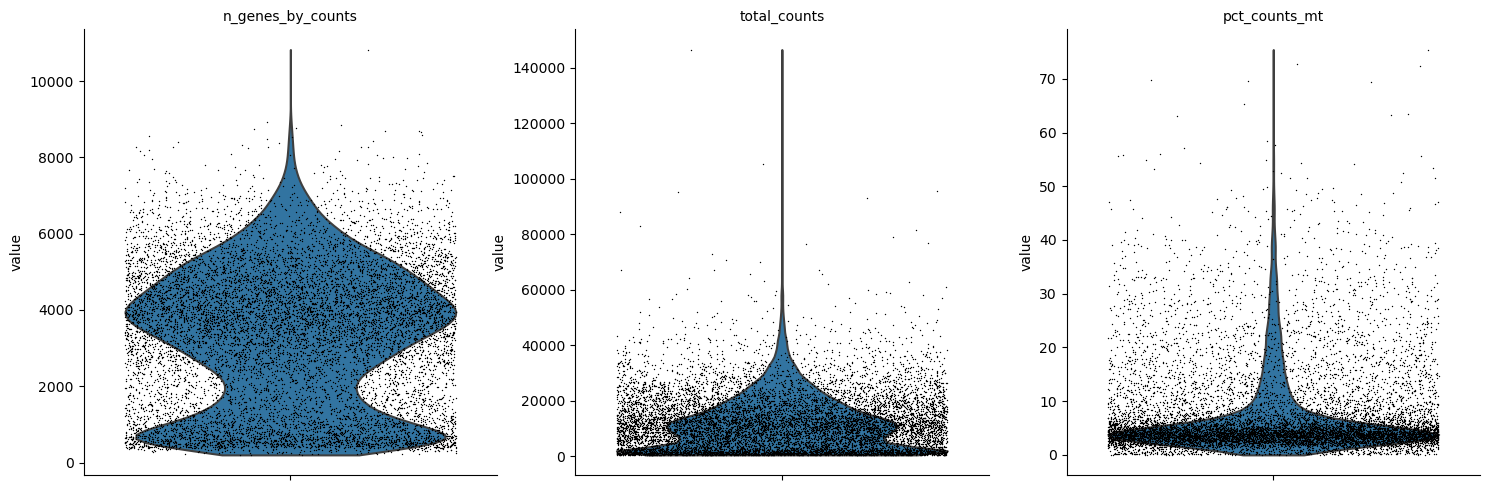

In [12]:
# generate violin plot: number of genes expressed, total counts per gene, percent of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

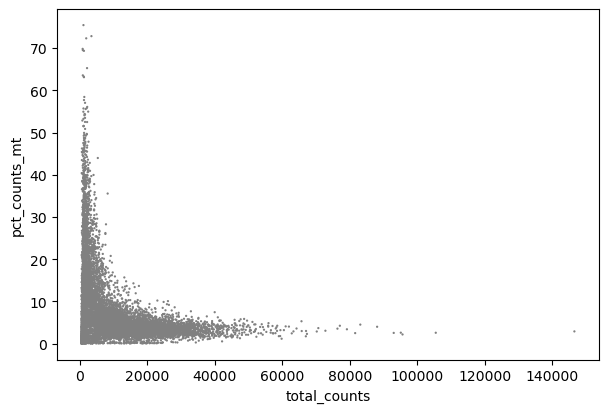

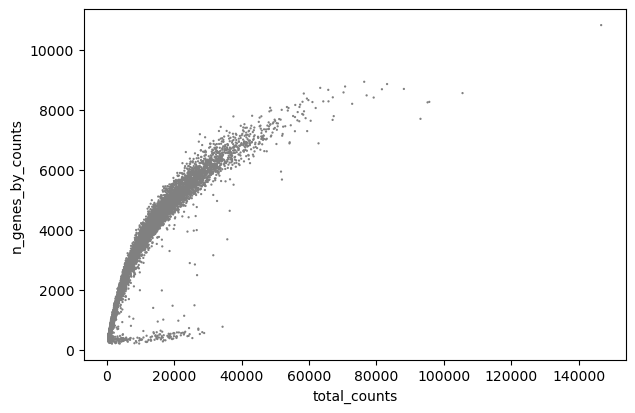

In [13]:
# total number of transcript counts detected in each cell
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# number of different genes that are detected in a cell. 
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
# keep cells with fewer than 2500 detected genes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# keep cells where the percentage of mitochondrial gene counts is less than 5%.
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [15]:
# normalize each cell's total expression to 10000
sc.pp.normalize_total(adata, target_sum=1e4)

C:\Users\Roger\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
# Logarithmization
sc.pp.log1p(adata)

In [17]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

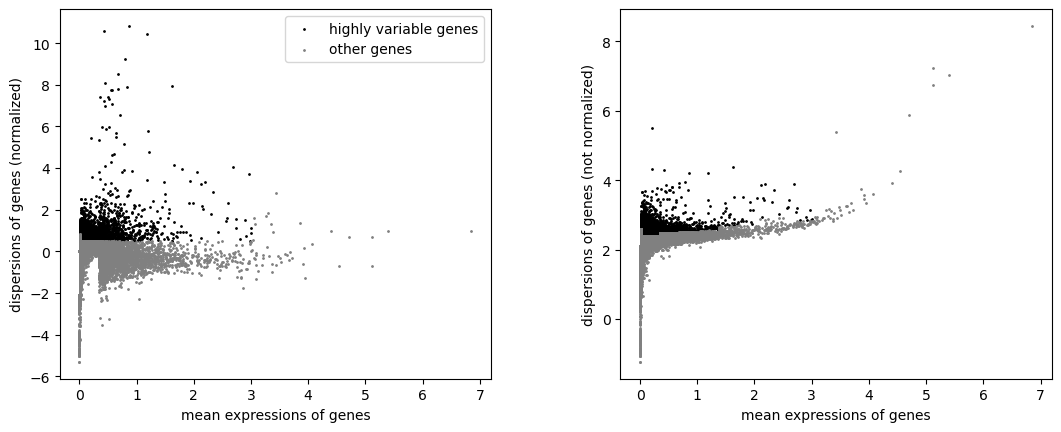

In [18]:
# compare HVG before and after normalization
sc.pl.highly_variable_genes(adata)

In [19]:
# save the current state of adata
adata.raw = adata

In [20]:
# filter for HVG
adata = adata[:, adata.var.highly_variable]

In [21]:
# apply regression-based correction of confounding factors
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [22]:
# scale each gene to unit variance
sc.pp.scale(adata, max_value=10)

### 3. Dimension Reduction: Principal Component Analysis

In [23]:
# apply PCA
sc.tl.pca(adata, svd_solver='arpack')

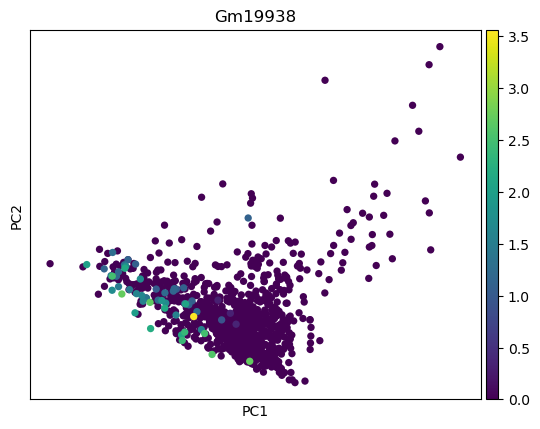

In [24]:
# visualize first 2 PCs of Gm19938
sc.pl.pca(adata, color='Gm19938')

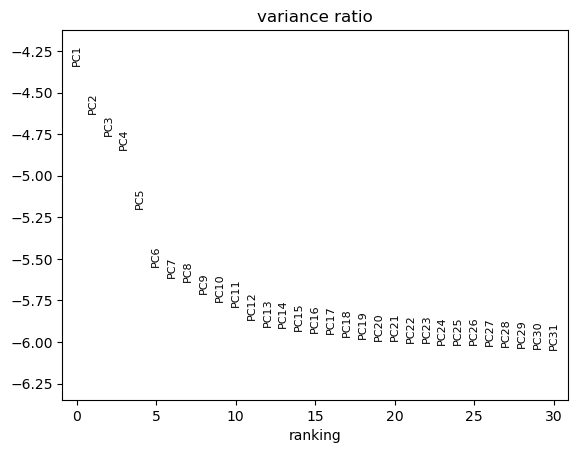

In [25]:
# visualized aggregated contribution of PCs to total variance explained
sc.pl.pca_variance_ratio(adata, log=True)
# 6 PCs will do

In [26]:
# create path to results
results_file = 'pbmc3k.h5ad'

In [27]:
# save current results
adata.write(results_file)

### 4. Neighborhood Graph

In [28]:
# computes the neighborhood graph of cells
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [29]:
# compute UMAP embedding
sc.tl.umap(adata)

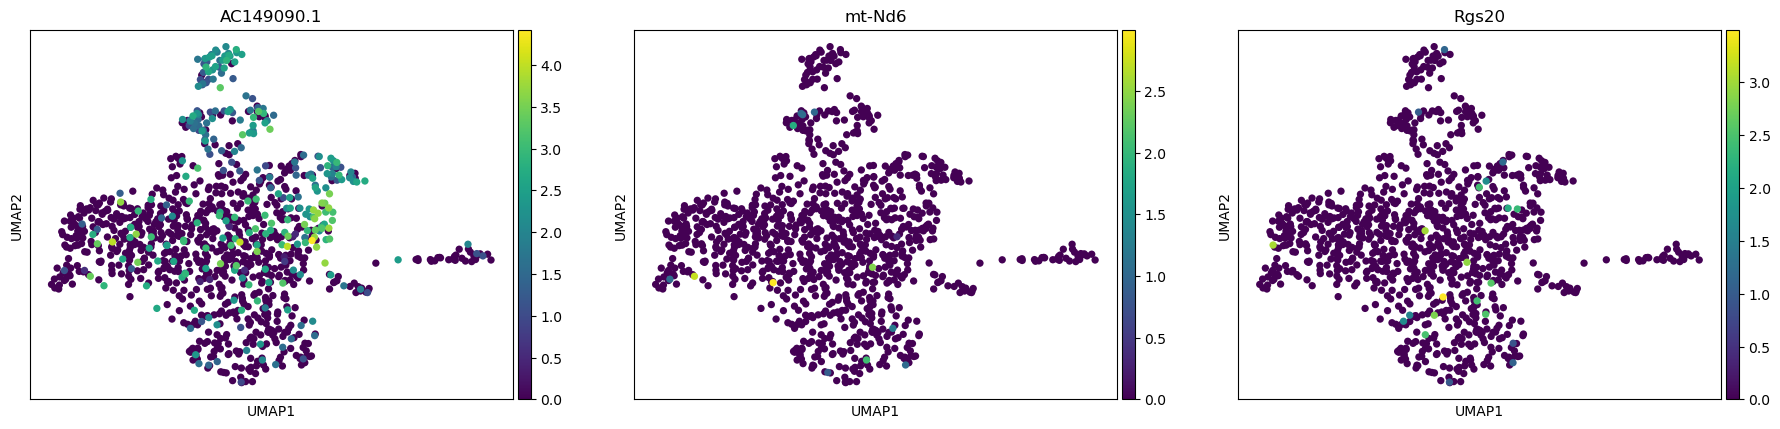

In [30]:
# generate UMAP plot for randomly selected genes
sc.pl.umap(adata, color=['AC149090.1', 'mt-Nd6', 'Rgs20'])

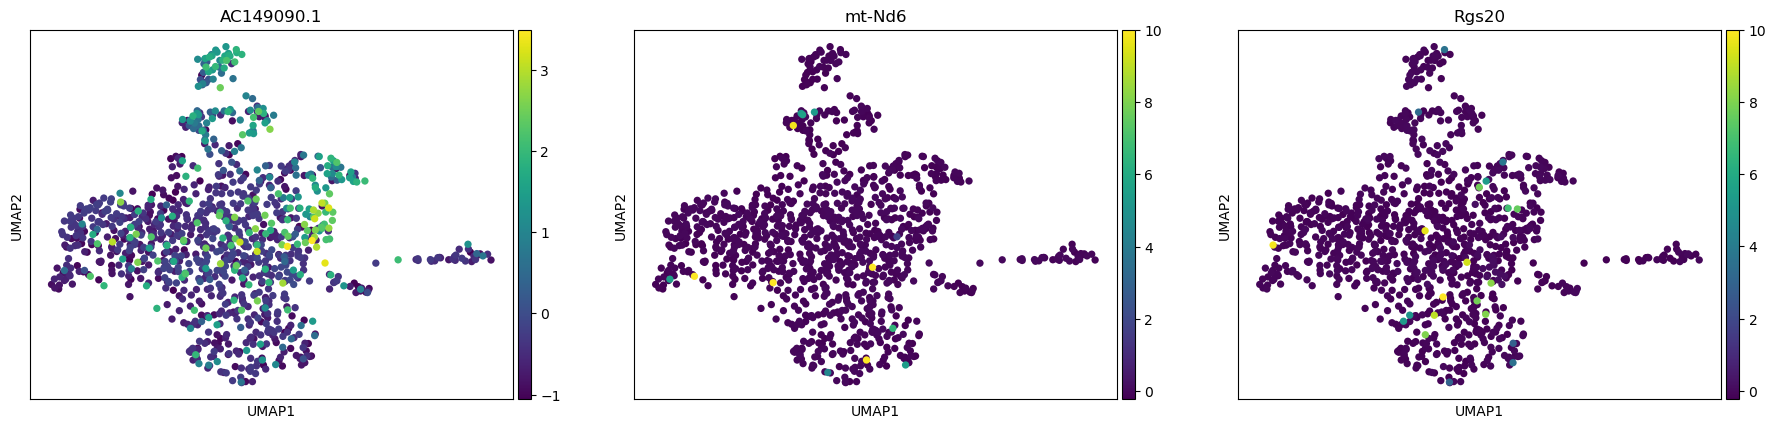

In [31]:
# generate UMAP plot with scaled and corrected gene expression
sc.pl.umap(adata, color=['AC149090.1', 'mt-Nd6', 'Rgs20'], use_raw=False)

### 5. Clustering neighborhood graph

In [32]:
# perform Leiden graph-clustering method
sc.tl.leiden(adata)

C:\Users\Roger\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


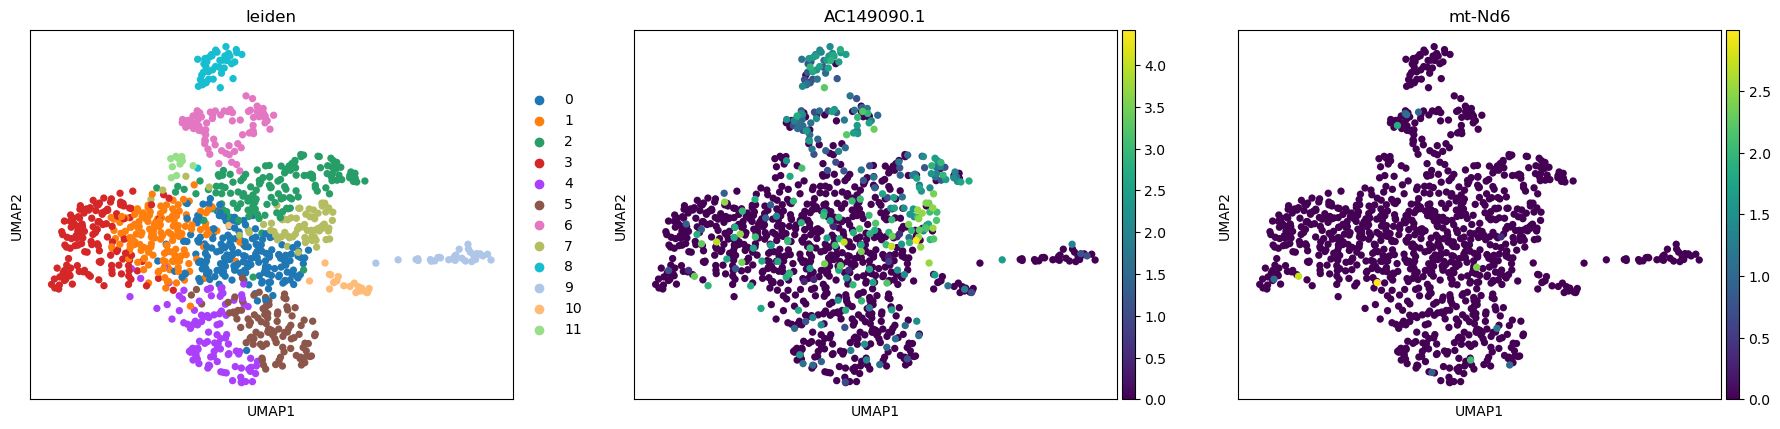

In [33]:
# visualize Leiden clustering and compare
sc.pl.umap(adata, color=['leiden', 'AC149090.1', 'mt-Nd6'])

In [34]:
# save current result
adata.write(results_file)

### 6. Finding marker genes

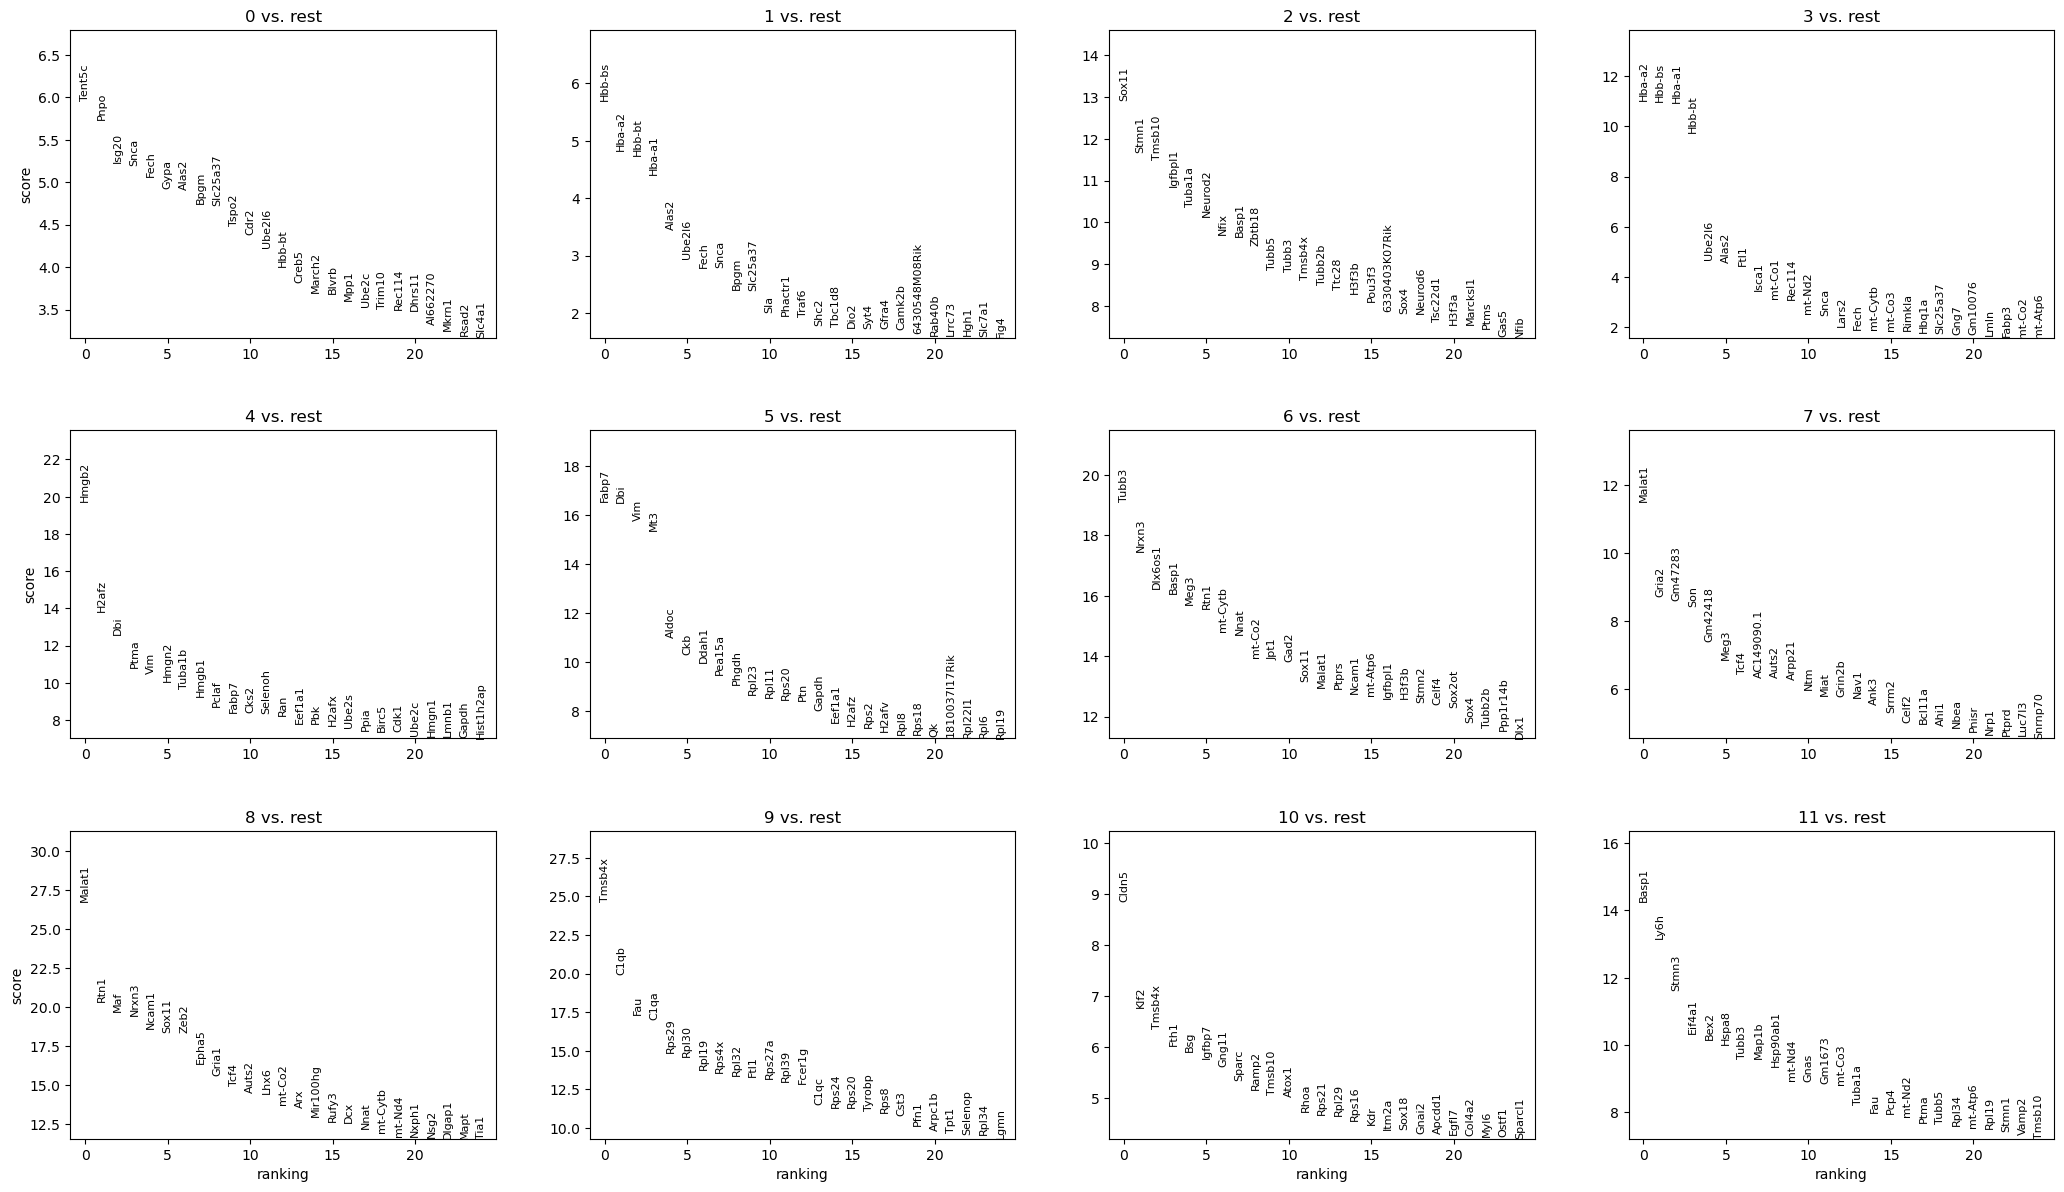

In [35]:
# compute and rank highly differential genes with t-test
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

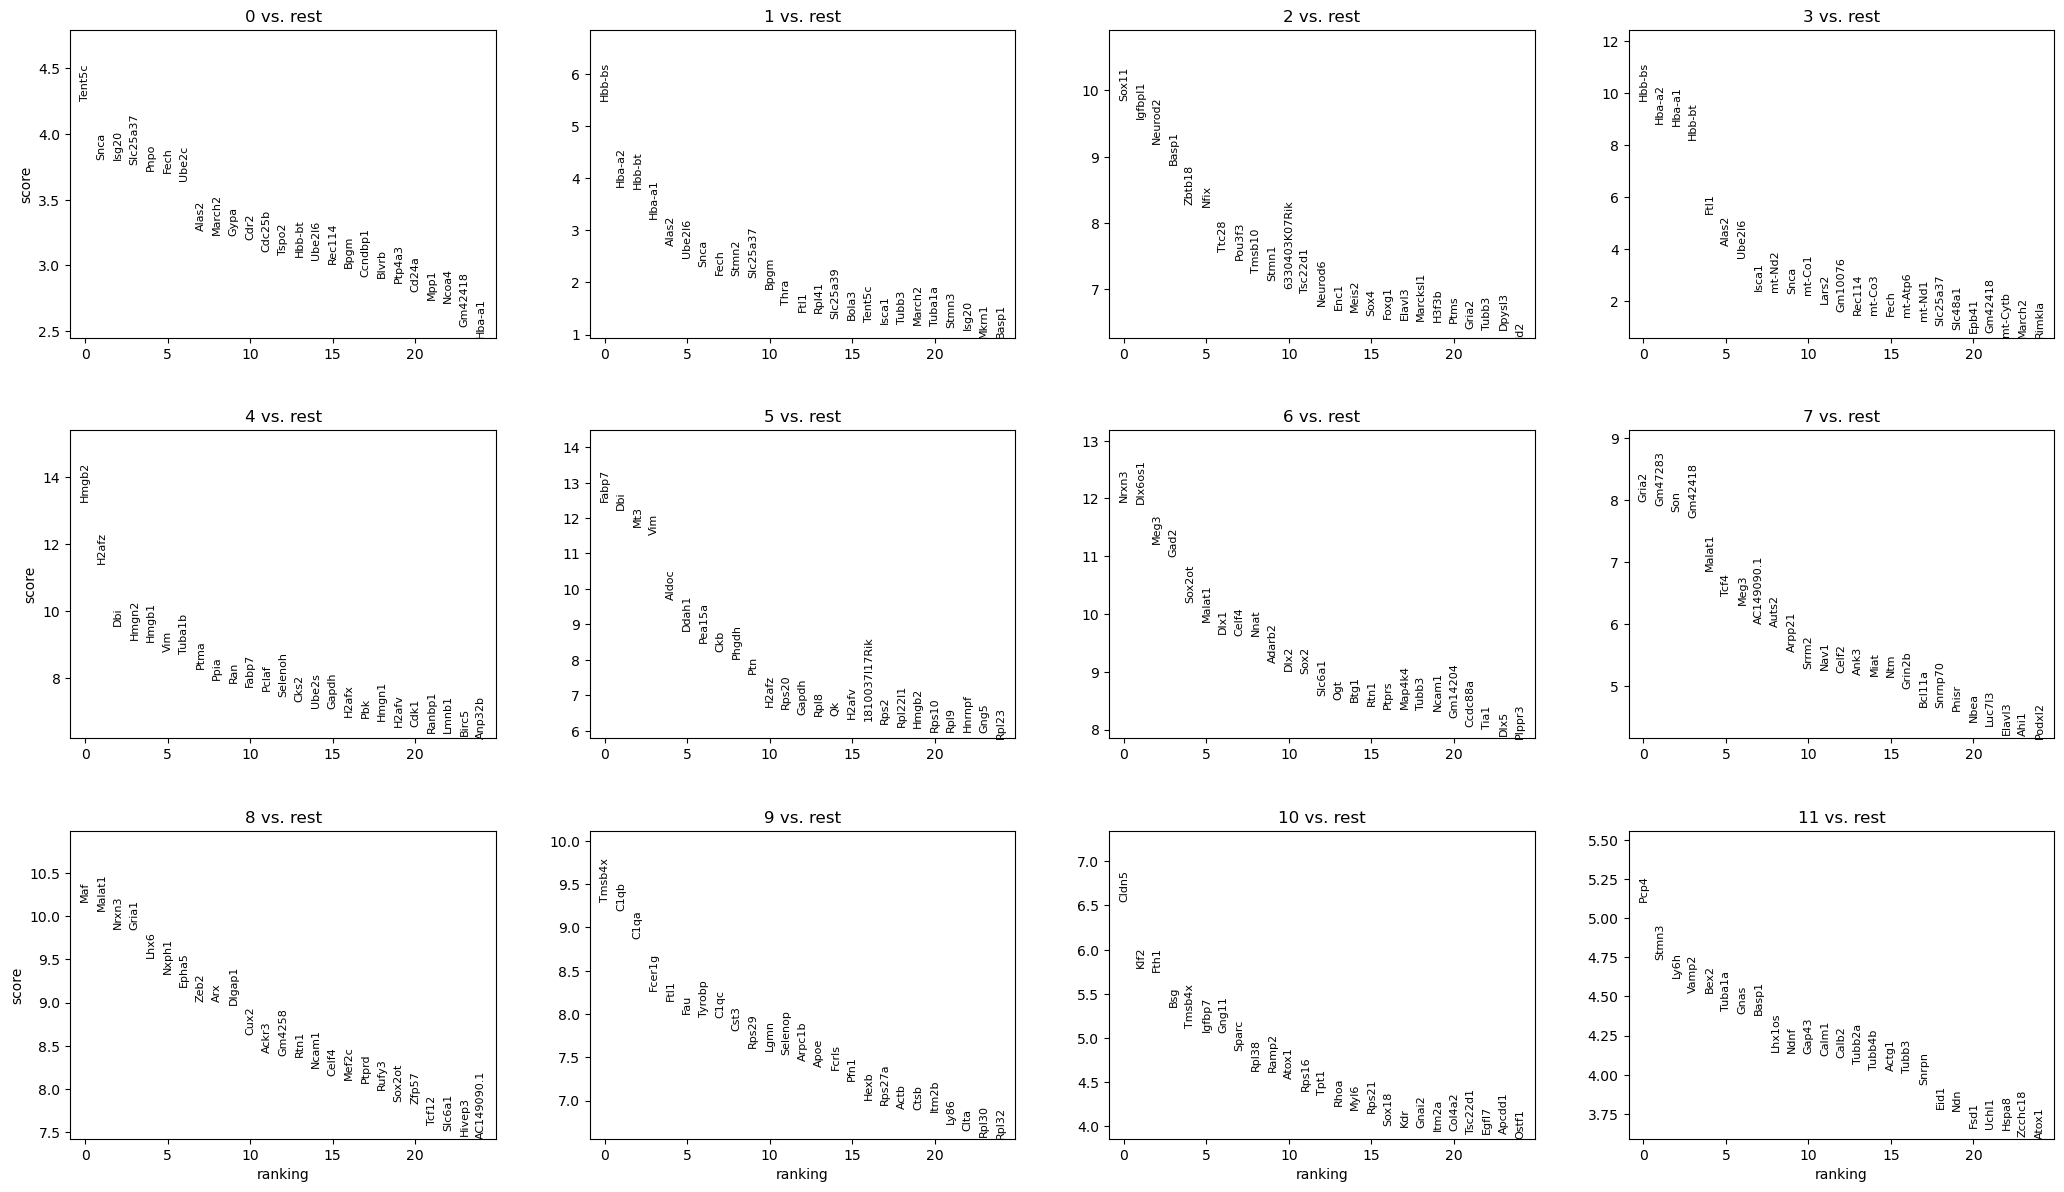

In [36]:
# compute and rank highly differential genes with Wilcoxon rank-sum (Mann-Whitney-U) test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
# save current results
adata.write(results_file)

C:\Users\Roger\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


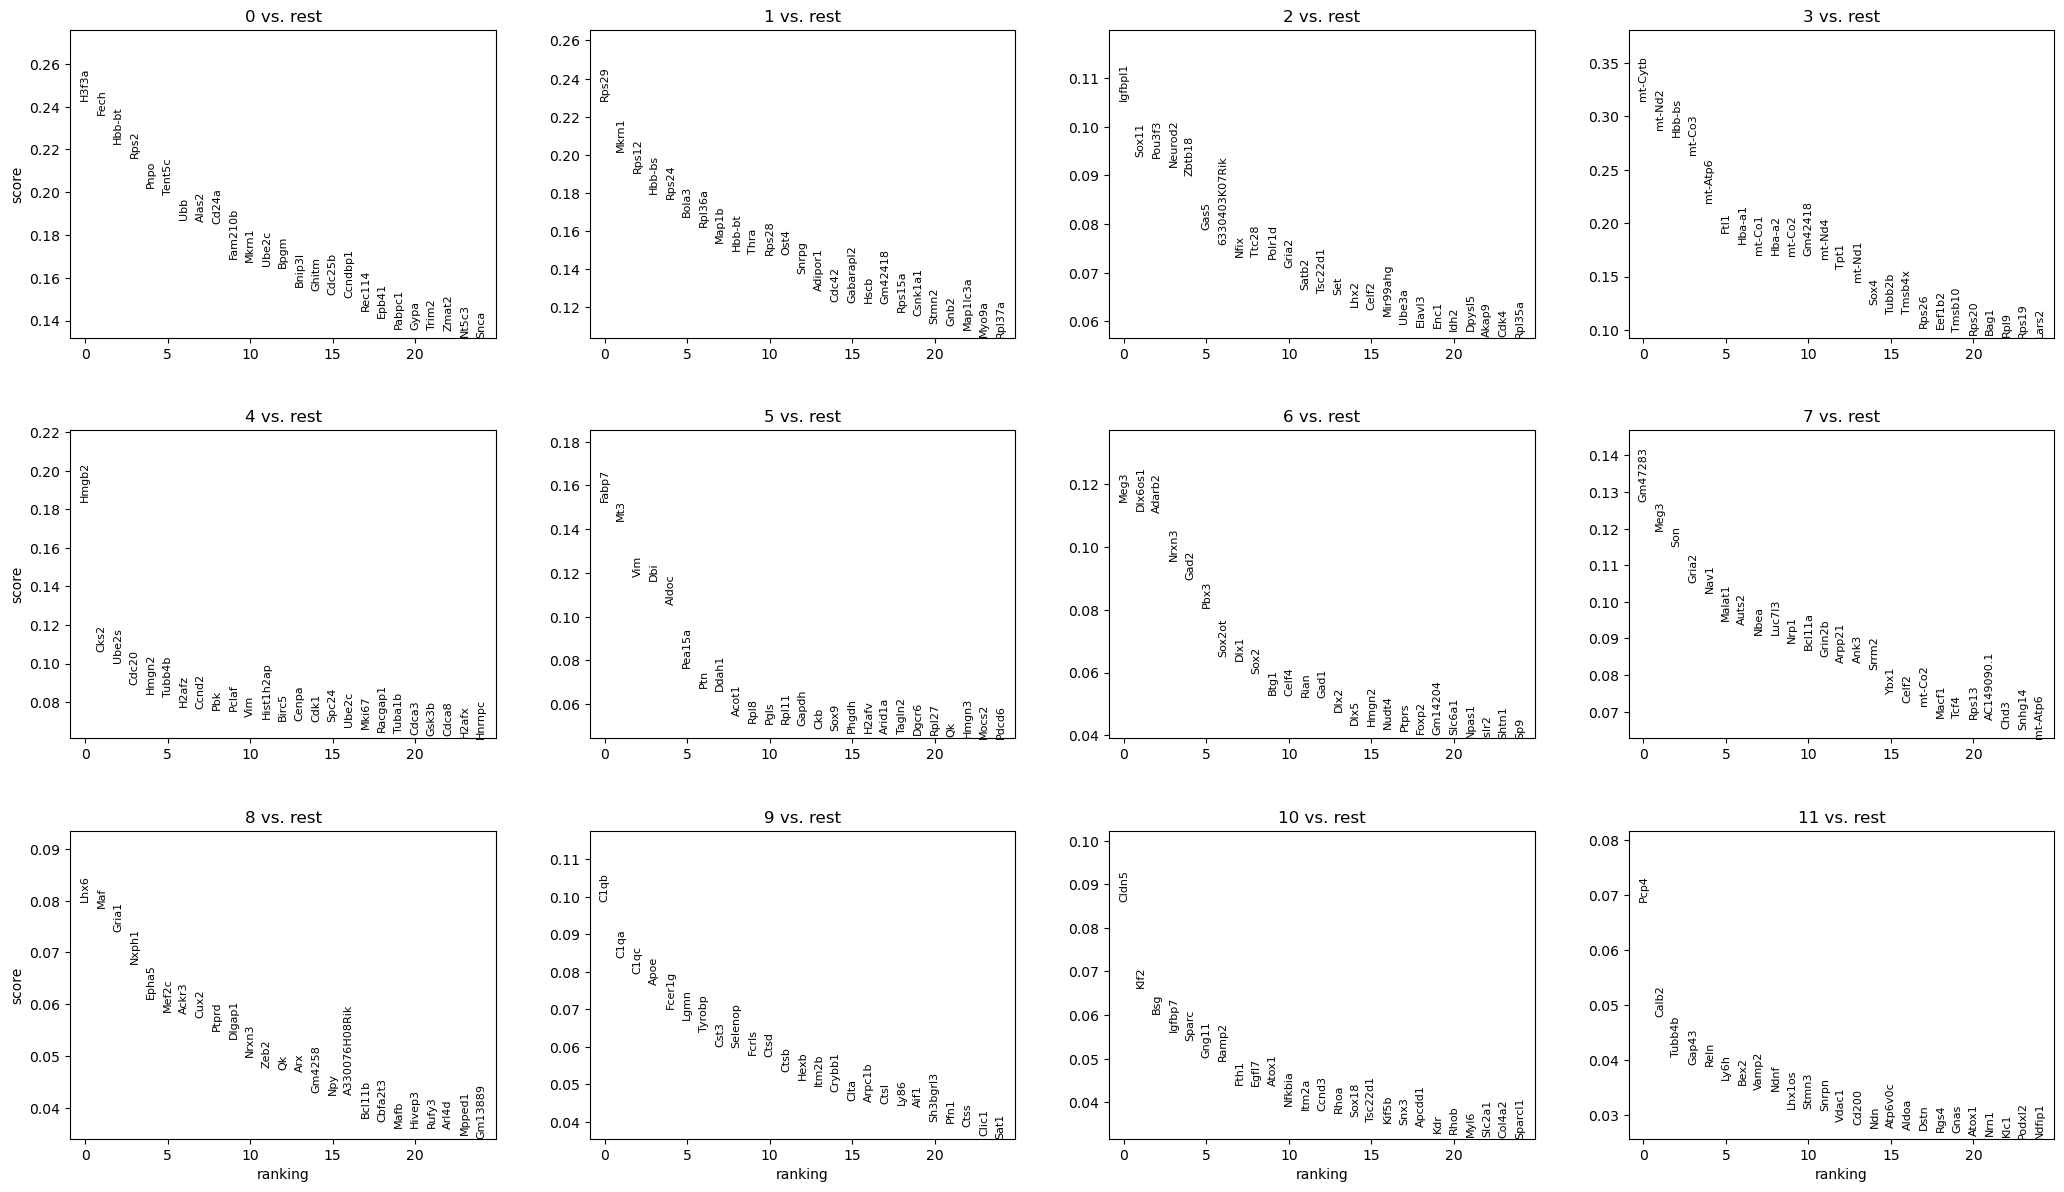

In [38]:
# compute and rank highly differential genes with logistic regression
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [39]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [40]:
# reload object with Wilcoxon Rank-Sum test result
adata = sc.read(results_file)

C:\Users\Roger\anaconda3\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [41]:
# show top genes in each cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Tent5c,Hbb-bs,Sox11,Hbb-bs,Hmgb2,Fabp7,Nrxn3,Gria2,Maf,Tmsb4x,Cldn5,Pcp4
1,Snca,Hba-a2,Igfbpl1,Hba-a2,H2afz,Dbi,Dlx6os1,Gm47283,Malat1,C1qb,Klf2,Stmn3
2,Isg20,Hbb-bt,Neurod2,Hba-a1,Dbi,Mt3,Meg3,Son,Nrxn3,C1qa,Fth1,Ly6h
3,Slc25a37,Hba-a1,Basp1,Hbb-bt,Hmgn2,Vim,Gad2,Gm42418,Gria1,Fcer1g,Bsg,Vamp2
4,Pnpo,Alas2,Zbtb18,Ftl1,Hmgb1,Aldoc,Sox2ot,Malat1,Lhx6,Ftl1,Tmsb4x,Bex2


In [42]:
# show top genes in each cluster with scores
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p
0,Tent5c,0.000021,Hbb-bs,4.083413e-08,Sox11,7.556723e-23,Hbb-bs,3.358892e-22,Hmgb2,3.063490e-40,...,Gria2,1.450970e-15,Maf,2.819874e-24,Tmsb4x,1.447225e-20,Cldn5,6.126111e-11,Pcp4,3.336249e-07
1,Snca,0.000141,Hba-a2,1.252836e-04,Igfbpl1,9.540454e-22,Hba-a2,1.036700e-18,H2afz,2.800417e-30,...,Gm47283,2.359543e-15,Malat1,7.943088e-24,C1qb,3.943139e-20,Klf2,6.592048e-09,Stmn3,2.178491e-06
2,Isg20,0.000141,Hbb-bt,1.410326e-04,Neurod2,3.546605e-20,Hba-a1,1.982131e-18,Dbi,9.998001e-22,...,Son,5.512792e-15,Nrxn3,6.188314e-23,C1qa,6.976806e-19,Fth1,8.911604e-09,Ly6h,3.792507e-06
3,Slc25a37,0.000165,Hba-a1,1.232667e-03,Basp1,6.555751e-19,Hbb-bt,2.514134e-16,Hmgn2,6.007896e-20,...,Gm42418,1.240592e-14,Gria1,7.170693e-23,Fcer1g,1.307534e-16,Bsg,8.810196e-08,Vamp2,6.045434e-06
4,Pnpo,0.000198,Alas2,6.710607e-03,Zbtb18,1.252338e-16,Ftl1,8.934194e-08,Hmgb1,8.857028e-20,...,Malat1,6.547812e-12,Lhx6,1.639516e-21,Ftl1,3.633477e-16,Tmsb4x,3.026330e-07,Bex2,6.059335e-06


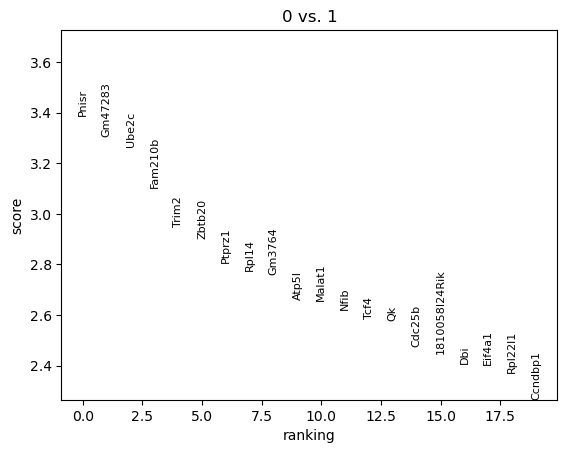

In [43]:
# compare ranking between cluster 0 and cluster 1
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

C:\Users\Roger\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


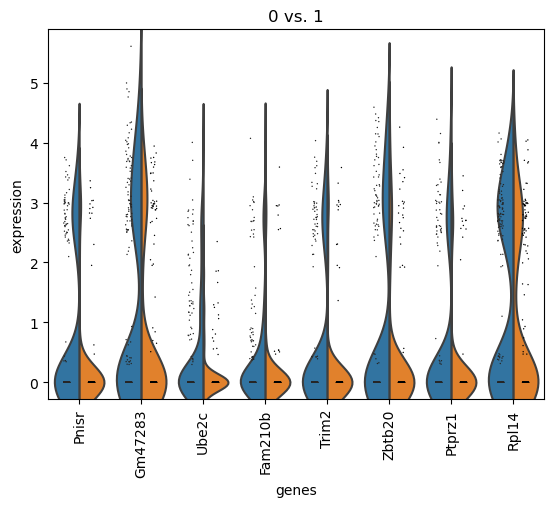

In [44]:
# compare cluster 0 and cluster 1 by violin plot
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [45]:
# reload object
adata = sc.read(results_file)

C:\Users\Roger\anaconda3\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


C:\Users\Roger\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


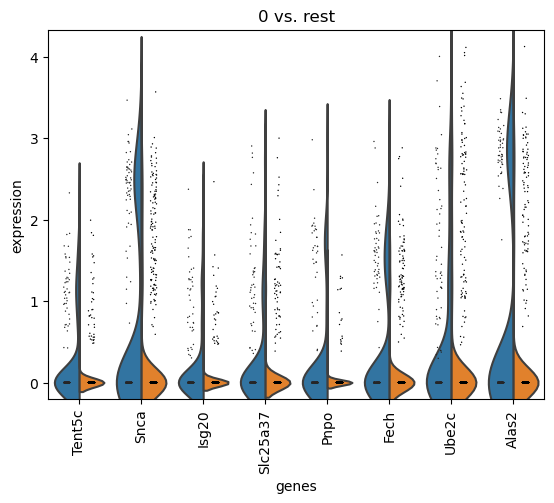

In [46]:
# compare cluster 0 and the rest by violin plot
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

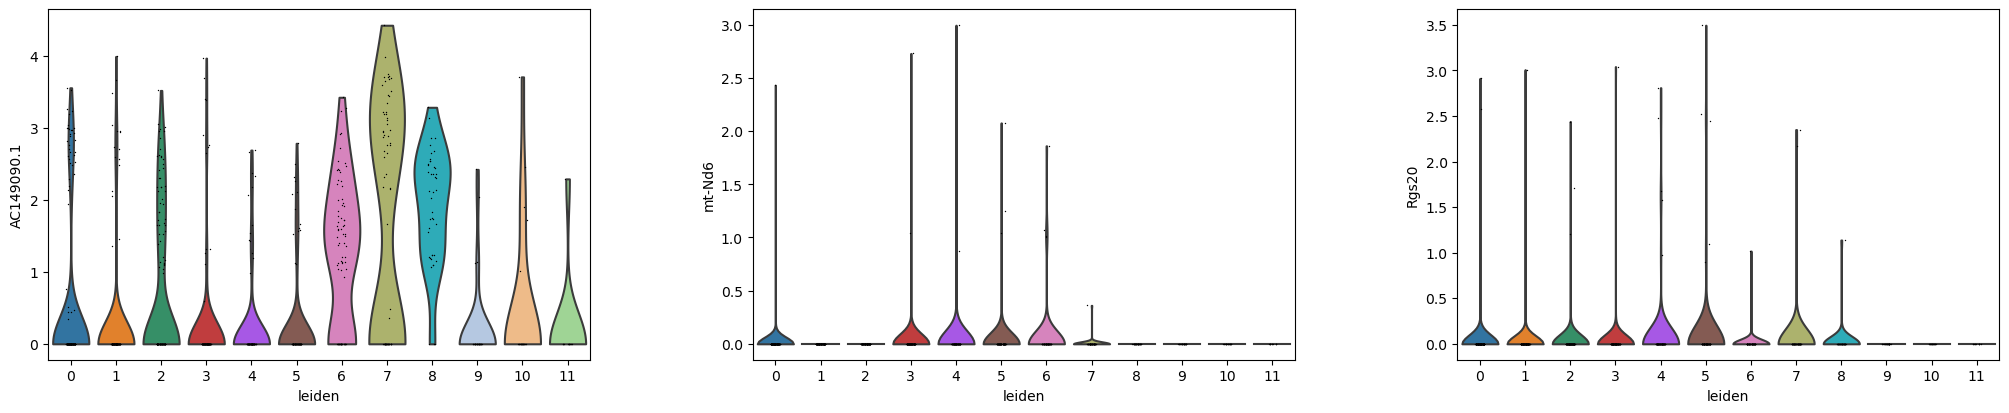

In [47]:
# compare specific genes by violin plots
sc.pl.violin(adata, ['AC149090.1', 'mt-Nd6', 'Rgs20'], groupby='leiden')

C:\Users\Roger\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


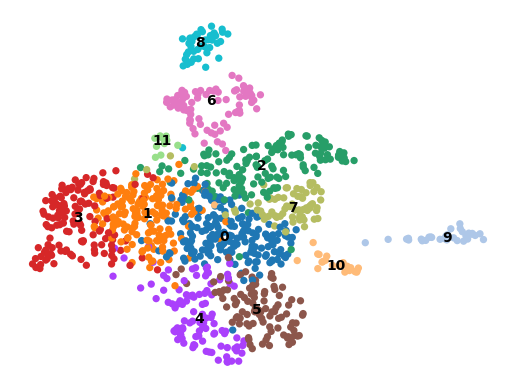

In [48]:
# mark the cell types with numbers, save the plot to pdf
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [49]:
# inspect final adata
adata

AnnData object with n_obs × n_vars = 1080 × 4440
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'